<a href="https://colab.research.google.com/github/leeraaz/SkinDiseaseDiagnosisNepal/blob/main/src/colab/ResNet50_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [7]:
# TPU Initialization
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU:", tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy()  # Default for CPU and GPU
    print("Running on", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")


Running on TPU: 


In [8]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 128 * strategy.num_replicas_in_sync  # Adjust batch size for TPU
EPOCHS = 20
LEARNING_RATE = 1e-4
# 1. Dataset Preparation
train_dir = '/content/drive/MyDrive/SkinDataset/data5/train'
test_dir = '/content/drive/MyDrive/SkinDataset/data5/test'

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes
class_labels = list(train_generator.class_indices.keys())
print("Classes:", class_labels)

# Compute Class Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


Found 5999 images belonging to 4 classes.
Found 2576 images belonging to 4 classes.
Classes: ['Acne', 'Eczema', 'Infection', 'Malignant']


In [ ]:
# 2. Build Model
def build_resnet50_model(num_classes):
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in resnet_base.layers[:-30]:
        layer.trainable = False
    for layer in resnet_base.layers[-30:]:
        layer.trainable = True
    input_tensor = Input(shape=(224, 224, 3))
    x = resnet_base(input_tensor)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=input_tensor, outputs=output_tensor)

with strategy.scope():
    model = build_resnet50_model(num_classes)
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=LEARNING_RATE, decay_steps=1000, alpha=0.00001
    )
    model.compile(optimizer=Adam(learning_rate=lr_schedule),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_2 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0   

In [ ]:
# 3. Training
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the trained model
model.save("/content/drive/MyDrive/SkinDataset/hybrid_model_resnet50.keras")

Epoch 1/20
47/47 [==============================] - 937s 20s/step - loss: 1.1361 - accuracy: 0.5918 - val_loss: 0.7293 - val_accuracy: 0.6957 - lr: 9.9479e-05
Epoch 2/20
47/47 [==============================] - 85s 2s/step - loss: 0.6921 - accuracy: 0.7260 - val_loss: 0.6760 - val_accuracy: 0.7372 - lr: 9.7881e-05
Epoch 3/20
47/47 [==============================] - 84s 2s/step - loss: 0.5545 - accuracy: 0.7806 - val_loss: 0.6252 - val_accuracy: 0.7741 - lr: 9.5241e-05
Epoch 4/20
47/47 [==============================] - 85s 2s/step - loss: 0.4586 - accuracy: 0.8200 - val_loss: 0.5833 - val_accuracy: 0.7970 - lr: 9.1617e-05
Epoch 5/20
47/47 [==============================] - 86s 2s/step - loss: 0.3785 - accuracy: 0.8540 - val_loss: 0.5524 - val_accuracy: 0.8055 - lr: 8.7087e-05
Epoch 6/20
47/47 [==============================] - 84s 2s/step - loss: 0.3077 - accuracy: 0.8821 - val_loss: 0.6373 - val_accuracy: 0.8075 - lr: 8.1750e-05
Epoch 7/20
47/47 [==============================] - 84s 

21/21 [==============================] - 15s 691ms/step - loss: 0.7716 - accuracy: 0.8505
Test Loss: 0.7715661525726318
accuracy: 0.8505434989929199
21/21 [==============================] - 32s 933ms/step

Classification Report:
              precision    recall  f1-score   support

        Acne       0.93      0.90      0.92       626
      Eczema       0.81      0.82      0.81       650
   Infection       0.75      0.79      0.77       650
   Malignant       0.93      0.90      0.91       650

    accuracy                           0.85      2576
   macro avg       0.85      0.85      0.85      2576
weighted avg       0.85      0.85      0.85      2576

Confusion Matrix:
 [[564  10  42  10]
 [ 19 533  86  12]
 [ 21  97 512  20]
 [  2  19  47 582]]
Macro-average ROC AUC: 0.9627819860776475
Micro-average ROC AUC: 0.9661131820403019


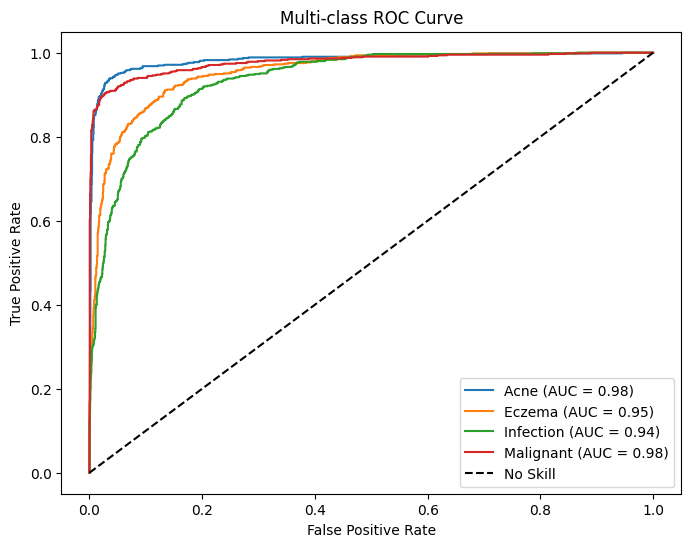

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

test_metrics = model.evaluate(test_generator)
print(f"Test Loss: {test_metrics[0]}")
for idx, metric_name in enumerate(model.metrics_names[1:], start=1):
    print(f"{metric_name}: {test_metrics[idx]}")


# 7. Classification Report & Confusion Matrix
y_pred_probs = model.predict(test_generator)
y_pred_indices = np.argmax(y_pred_probs, axis=1)
y_true_indices = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true_indices, y_pred_indices, target_names=class_labels))

cm = confusion_matrix(y_true_indices, y_pred_indices)
print("Confusion Matrix:\n", cm)

# 8. Multi-class ROC & AUC
y_true_binarized = label_binarize(y_true_indices, classes=range(num_classes))

macro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs,
                              multi_class='ovr', average='macro')
micro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs,
                              multi_class='ovr', average='micro')
print("Macro-average ROC AUC:", macro_roc_auc)
print("Micro-average ROC AUC:", micro_roc_auc)

fpr = {}
tpr = {}
roc_auc_classwise = {}

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc_classwise[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label='{} (AUC = {:.2f})'.format(class_labels[i], roc_auc_classwise[i]))

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

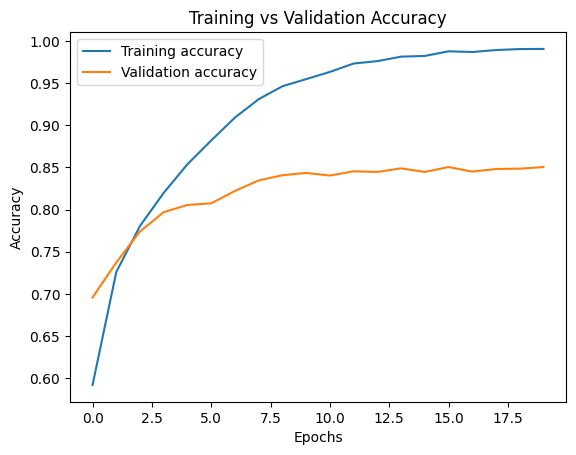

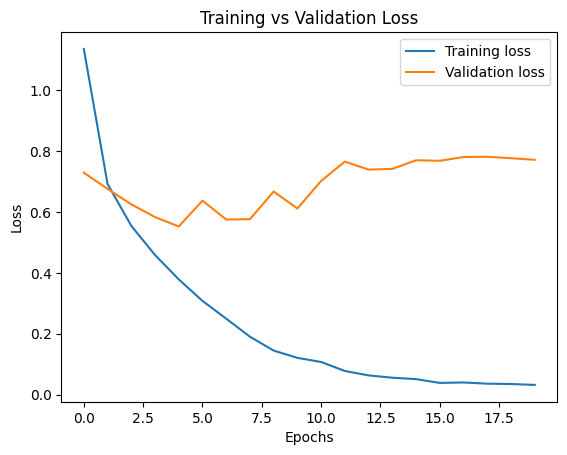

In [ ]:
# Plot training and validation curves
def plot_training_results(history, metrics=["accuracy", "loss"]):
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_training_results(history, metrics=["accuracy", "loss"])

In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/SkinDataset/hybrid_model_resnet50.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the model
model = load_model("/content/drive/MyDrive/SkinDataset/hybrid_model_resnet50.keras")

# Re-save the model explicitly using the current TensorFlow version
model.save("/content/drive/MyDrive/SkinDataset/hybrid_model_resnet50_fixed.keras")


In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/SkinDataset/hybrid_model_resnet50_fixed.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the model
model = load_model("/content/drive/MyDrive/SkinDataset/hybrid_model_resnet50.keras")

21/21 [==============================] - 410s 20s/step - loss: 0.7714 - accuracy: 0.8509
Test Loss: 0.7713508605957031
accuracy: 0.850931704044342
21/21 [==============================] - 43s 2s/step

Classification Report:
              precision    recall  f1-score   support

        Acne       0.93      0.90      0.91       626
      Eczema       0.81      0.82      0.81       650
   Infection       0.75      0.79      0.77       650
   Malignant       0.93      0.90      0.91       650

    accuracy                           0.85      2576
   macro avg       0.85      0.85      0.85      2576
weighted avg       0.85      0.85      0.85      2576

Confusion Matrix:
 [[564  10  42  10]
 [ 19 533  86  12]
 [ 22  96 513  19]
 [  2  19  47 582]]
Macro-average ROC AUC: 0.9627970781536666
Micro-average ROC AUC: 0.9661178034540849


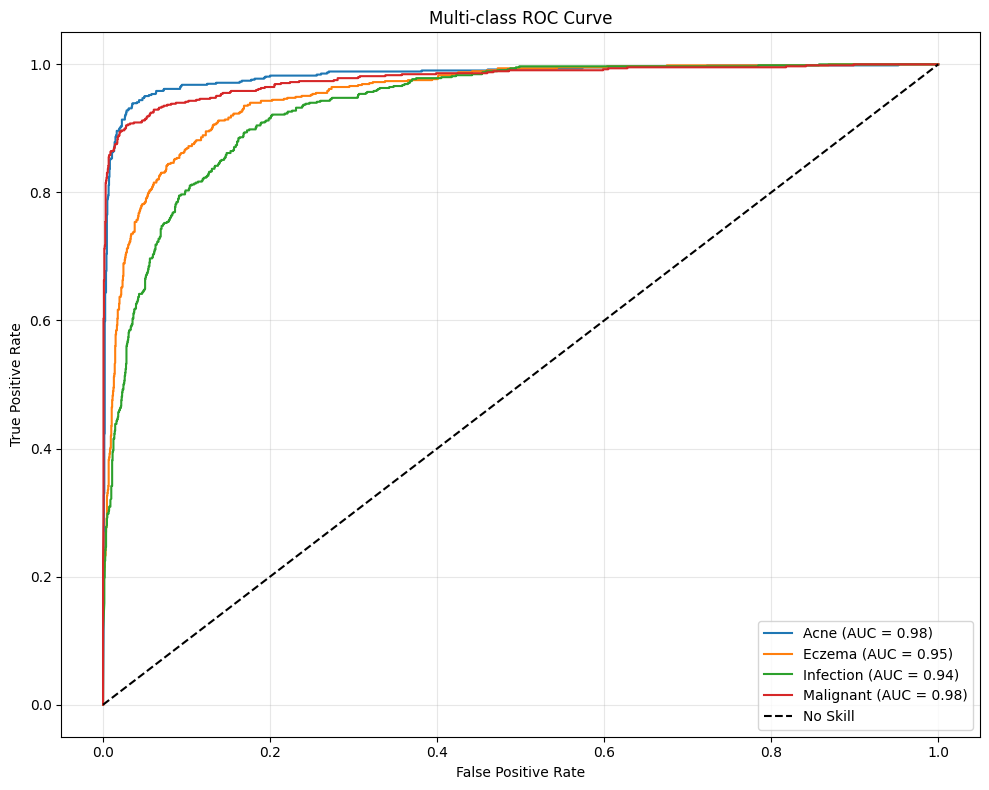

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

# Evaluate the model
test_metrics = model.evaluate(test_generator)
print(f"Test Loss: {test_metrics[0]}")
for idx, metric_name in enumerate(model.metrics_names[1:], start=1):
    print(f"{metric_name}: {test_metrics[idx]}")

# Classification Report & Confusion Matrix
y_pred_probs = model.predict(test_generator)
y_pred_indices = np.argmax(y_pred_probs, axis=1)
y_true_indices = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true_indices, y_pred_indices, target_names=class_labels))

cm = confusion_matrix(y_true_indices, y_pred_indices)
print("Confusion Matrix:\n", cm)

# Multi-class ROC & AUC
y_true_binarized = label_binarize(y_true_indices, classes=range(num_classes))
macro_roc_auc = roc_auc_score(
    y_true_binarized, y_pred_probs, multi_class='ovr', average='macro'
)
micro_roc_auc = roc_auc_score(
    y_true_binarized, y_pred_probs, multi_class='ovr', average='micro'
)
print("Macro-average ROC AUC:", macro_roc_auc)
print("Micro-average ROC AUC:", micro_roc_auc)

# Plot ROC Curves
plt.figure(figsize=(10, 8))
fpr, tpr, roc_auc_classwise = {}, {}, {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc_classwise[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc_classwise[i]:.2f})')

# Add No-Skill Line
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')

# Graph aesthetics
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
from sklearn.metrics import classification_report

# Generate classification report as a dictionary
report_dict = classification_report(
    y_true_indices, y_pred_indices, target_names=class_labels, output_dict=True
)

# Convert to DataFrame for better visualization
report_df = pd.DataFrame(report_dict).transpose()
print("\nClassification Report (Tabular):")
print(report_df)


Classification Report (Tabular):
              precision    recall  f1-score      support
Acne           0.929160  0.900958  0.914842   626.000000
Eczema         0.810030  0.820000  0.814985   650.000000
Infection      0.745640  0.789231  0.766816   650.000000
Malignant      0.934189  0.895385  0.914375   650.000000
accuracy       0.850932  0.850932  0.850932     0.850932
macro avg      0.854755  0.851393  0.852755  2576.000000
weighted avg   0.854062  0.850932  0.852176  2576.000000


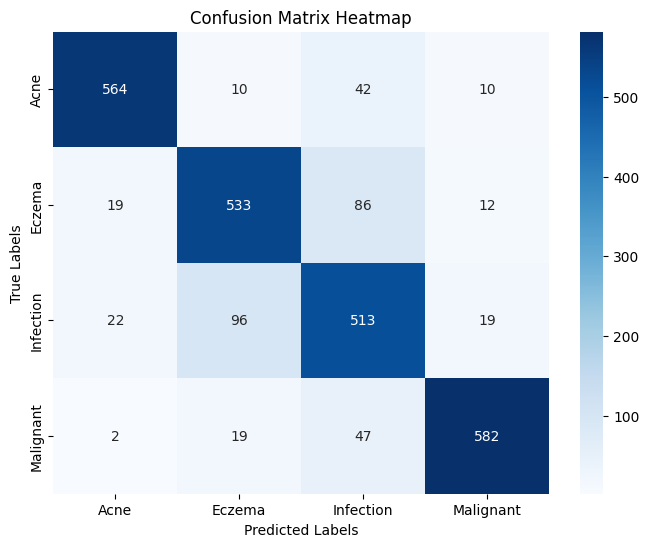

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true_indices, y_pred_indices)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_labels, yticklabels=class_labels
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


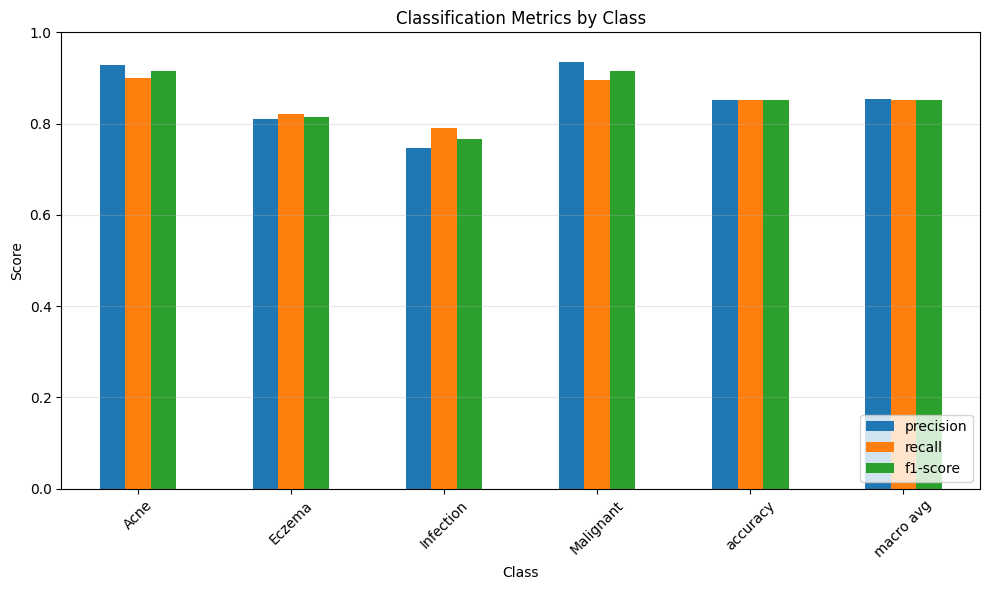

In [12]:
# Extract precision, recall, and F1-score
metrics_df = report_df.iloc[:-1, :3]  # Exclude 'accuracy', and keep P, R, F1

# Plot metrics as a bar chart
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title("Classification Metrics by Class")
plt.ylabel("Score")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.legend(loc='lower right')
plt.show()
